In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import random


In [ ]:
VOCAB_SIZE = 30000
PAD_TOKEN_ID = 0
BOS_TOKEN_ID = 1
EOS_TOKEN_ID = 2
MAX_LEN = 32


In [ ]:
class DummySeq2SeqDataset(Dataset):
    def __init__(self, num_samples=128, max_len=MAX_LEN, vocab_size=VOCAB_SIZE):
        self.samples = []
        for _ in range(num_samples):
            input_len = random.randint(5, max_len)
            output_len = random.randint(5, max_len)

            input_ids = [random.randint(3, vocab_size - 1) for _ in range(input_len)]
            output_ids = [BOS_TOKEN_ID] + [random.randint(3, vocab_size - 1) for _ in range(output_len - 2)] + [EOS_TOKEN_ID]

            self.samples.append((input_ids, output_ids))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [ ]:
def collate_fn(batch):
    input_ids, output_ids = zip(*batch)

    def pad_and_create_mask(sequences, pad_token_id=PAD_TOKEN_ID):
        max_len = max(len(seq) for seq in sequences)
        padded = [seq + [pad_token_id] * (max_len - len(seq)) for seq in sequences]
        mask = [[1] * len(seq) + [0] * (max_len - len(seq)) for seq in sequences]
        return torch.tensor(padded), torch.tensor(mask)

    # Pad encoder input
    input_ids, input_attention_mask = pad_and_create_mask(input_ids)

    # Pad decoder input and output (we need shifted inputs for decoder and labels)
    decoder_input_ids = [seq[:-1] for seq in output_ids]  # Remove last token
    decoder_labels = [seq[1:] for seq in output_ids]      # Remove first token

    decoder_input_ids, decoder_attention_mask = pad_and_create_mask(decoder_input_ids)
    decoder_labels, _ = pad_and_create_mask(decoder_labels)

    return {
        'input_ids': input_ids,
        'input_attention_mask': input_attention_mask,
        'decoder_input_ids': decoder_input_ids,
        'decoder_attention_mask': decoder_attention_mask,
        'labels': decoder_labels
    }


In [ ]:
dataset = DummySeq2SeqDataset(num_samples=64)  # You can scale this up
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
a = torch.ones(size = (3,3),dtype = torch.long)
print(a)
a = torch.tril(a)
print(a)
#this will be useful when i write the masked self attention bcoz this is what is needed for causal masking.

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])
tensor([[1, 0, 0],
        [1, 1, 0],
        [1, 1, 1]])


Assume both input and output are tokenized already.

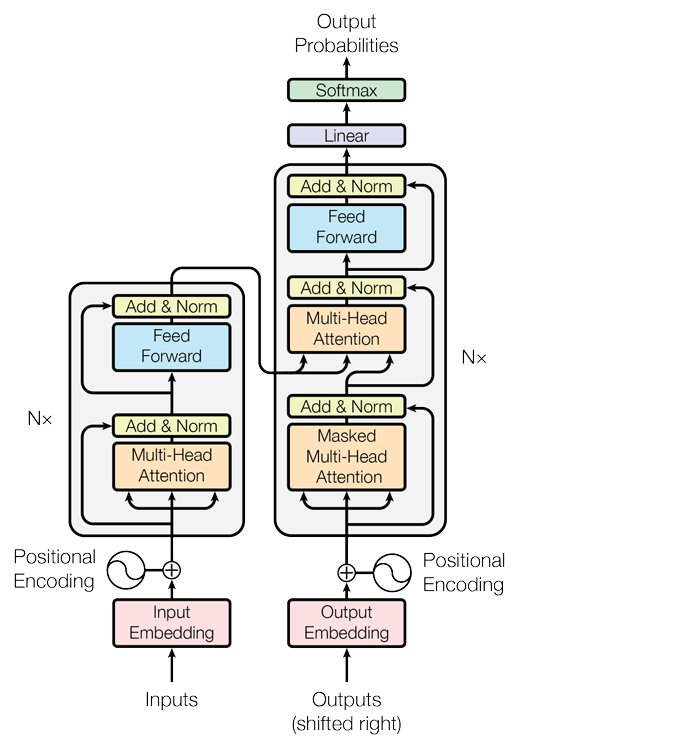

In [ ]:
dataset = Dataset()

dataloader = DataLoader(batch_size, random_shuffle, etc)



In [ ]:
max_sequence_length = 512
batch_size = 256
position_ids = torch.arange(max_sequence_length)
#print(position_ids)
print(position_ids.shape)
p = position_ids.unsqueeze(0)
print(p.shape)
#-1 means not changing size of that dimension
q = p.expand(batch_size, -1)
print(q.shape)

torch.Size([512])
torch.Size([1, 512])
torch.Size([256, 512])


In [ ]:
class Embedding(nn.Module):
  def __init__(self, vocab_size, hidden_size, max_position_embeddings, dropout = 0.1):
    #i will instantiate this class differently depending on whether its encoder layer or decoder
    super().__init__()

    self.token_embed = nn.Embedding(vocab_size, hidden_size)
    self.position_embed = nn.Embedding(max_position_embeddings, hidden_size)

    self.dropout = nn.Dropout(dropout)

    self.layernorm = nn.LayerNorm(hidden_size)

  def forward(self, input_ids):
    #what is x. x is actually the tokenized inputs. what shape will it have?
    # x is a batch. each batch has size B and max sequence length which may be padded and an attention mask
    # x is going to be a B x L. so in each batch there are say 256 sentences. each sentence is tokenized and padded or truncated
    # to 512 tokens, say. so x is B x L
    # token type ids not needed here.
    """
    Args:
        input_ids: Tensor of shape [Batch_Size, Seq_Length]

    Returns:
        embeddings: Tensor of shape [Batch_Size, Seq_Length, Hidden_Size]
    """
    B, L = input_ids.shape
    token_embeddings = self.token_embed(input_ids)
    position_ids = torch.arange(L, device = input_ids.device).unsqueeze(0).expand(B, -1) #BxL
    position_embeddings = self.position_embed(position_ids)

    embeddings = token_embeddings + position_embeddings # B x L x H

    embeddings = self.layernorm(embeddings)
    embeddings = self.dropout(embeddings)

    return embeddings

In [ ]:
#same MultiHeadSelfAttention class for encoder and decoder. there will be 3 types of attentions.
#1) in the encoder: attention will be bi directional
#2) in decoder, first there will be masked attention in which we need the causal mask
#3) in decoder, there will be further cross self attention between queries from decoder and keys and values from the encoder so that
#the decoder can learn to attend to the input sequence as well.

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, hidden_size, dropout = 0.1, causal_masking = False):
    super().__init__()
    assert hidden_size % num_heads == 0

    self.num_heads = num_heads
    self.hidden_size = hidden_size
    self.causal_masking = causal_masking

    self.query = nn.Linear(hidden_size, hidden_size)
    self.key = nn.Linear(hidden_size, hidden_size)
    self.value = nn.Linear(hidden_size, hidden_size)

    self.dropout = nn.Dropout(dropout)

    self.out_proj = nn.Linear(hidden_size, hidden_size)

    self.head_dim = hidden_size // num_heads
    self.scale = math.sqrt(self.head_dim)

  def forward(self, x, mask = None, kv_input = None):
    # kv_input is useful during cross attention. so k and v come from encoder, q comes from decoder
    #input here is the embeddings of shape B x L x H
    B, L_q, H = x.shape

    if kv_input is None:
      kv_input = x

    B_kv, L_kv, H_kv = kv_input.shape

    Q = self.query(x)
    K = self.key(kv_input)
    V = self.value(kv_input)

    Q = Q.view(B, L_q, self.num_heads, self.head_dim).transpose(1, 2)
    K = K.view(B, L_kv, self.num_heads, self.head_dim).transpose(1, 2)
    V = V.view(B, L_kv, self.num_heads, self.head_dim).transpose(1, 2)
    # Attention Scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # B x Heads x L_q x L_kv

    # Apply causal mask if needed (for decoder self-attention)
    if self.causal_masking:
        causal_mask = torch.triu(torch.ones((L_q, L_kv), device=x.device), diagonal=1).bool()
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # [1,1,L_q,L_kv]
        scores = scores.masked_fill(causal_mask, float('-inf'))

    # Apply padding mask if provided (for ignoring pad tokens)
    if mask is not None:
        # mask should be [B, 1, 1, L_kv] shape for broadcasting.
        scores = scores.masked_fill(mask == 0, float('-inf'))

    attention_weights = F.softmax(scores, dim=-1)
    attention_weights = self.dropout(attention_weights)

    attention_output = torch.matmul(attention_weights, V)  # B x Heads x L_q x Head_dim
    attention_output = attention_output.transpose(1, 2).contiguous().view(B, L_q, H)

    output = self.out_proj(attention_output)

    return output


In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, num_heads, hidden_size, intermediate_size, dropout = 0.1):
    super().__init__()

    self.self_attention = MultiHeadAttention(num_heads,hidden_size,dropout,causal_masking = False)

    self.attention_norm = nn.LayerNorm(hidden_size)

    self.ff = nn.Sequential(
        nn.Linear(hidden_size, intermediate_size),
        nn.GELU(),
        nn.Linear(intermediate_size, hidden_size),
        nn.Dropout(dropout)
    )

    self.ff_norm = nn.LayerNorm(hidden_size)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask = None):
    #input to one encoder layer is B x L x H
    attention_output = self.self_attention(x,mask)

    x = self.attention_norm(x + self.dropout(attention_output))

    ff_output = self.ff(x)

    x = self.ff_norm(x + self.dropout(ff_output))

    return x # B x L x H


In [ ]:
class Encoder(nn.Module):
  def __init__(self, num_encoder_layers, num_heads, hidden_size, intermediate_size, dropout = 0.1):
    super().__init__()
    self.encoder_layers = nn.ModuleList([
        EncoderLayer(num_heads, hidden_size, intermediate_size, dropout)
        for _ in range(num_encoder_layers)
    ])

  def forward(self, x, mask = None):
    #x comes from Embedding layer. So the input is of shape B x L x H
    for encoder_layer in self.encoder_layers:
      x = encoder_layer(x, mask)
    return x

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, num_heads, hidden_size, intermediate_size, dropout = 0.1):
    super().__init__()
    self.self_attention = MultiHeadAttention(num_heads,hidden_size,dropout,causal_masking = True)

    self.norm1 = nn.LayerNorm(hidden_size)

    self.cross_attention = MultiHeadAttention(num_heads, hidden_size, dropout, causal_masking = False)
    self.norm2 = nn.LayerNorm(hidden_size)

    self.ff = nn.Sequential(
        nn.Linear(hidden_size, intermediate_size),
        nn.GELU(),
        nn.Linear(intermediate_size, hidden_size),
        nn.Dropout(dropout)
    )

    self.norm3 = nn.LayerNorm(hidden_size)

    self.dropout = nn.Dropout(dropout)

  def forward(self, y, encoder_output, tgt_mask=None, memory_mask=None):
    #tgt_mask is the mask for the target tokenized version to mask the <pad>
    #and memory_mask is the mask for the encoder's output both are just normals masks for nulling the <pad> tokens

    #first there is masked attention.
    self_attention_output = self.self_attention(y, mask = tgt_mask)
    y = self.norm1(y + self.dropout(self_attention_output))

    #then there is cross attention with encoder's keys and values
    cross_attention_output = self.cross_attention(y, mask=memory_mask, kv_input=encoder_output)
    y = self.norm2(y + self.dropout(cross_attention_output))

    #then finally feedforward layer
    ff_output = self.ff(y)
    y = self.norm3(y + self.dropout(ff_output))

    return y

In [ ]:
class Decoder(nn.Module):
  def __init__(self, num_decoder_layers, num_heads, hidden_size, intermediate_size, dropout = 0.1):
    super().__init__()
    self.decoder_layers = nn.ModuleList([
        DecoderLayer(num_heads, hidden_size, intermediate_size, dropout)
        for _ in range(num_decoder_layers)
    ])

  def forward(self, x, encoder_output, tgt_mask = None, memory_mask = None):
    for decoder_layer in self.decoder_layers:
      x = decoder_layer(x, encoder_output, tgt_mask, memory_mask)
    return x

In [ ]:
class Transformer(nn.Module):
  def __init__(self, input_vocab_size, input_hidden_size, max_input_position_embeddings, output_vocab_size,
               output_hidden_size, max_output_position_embeddings, dropout,
               num_encoder_layers, num_encoder_heads,input_intermediate_size,
               num_decoder_layers, num_decoder_heads, output_intermediate_size,
               ):
    super().__init__()

    self.input_embeds = Embedding(input_vocab_size, input_hidden_size, max_input_position_embeddings, dropout)

    self.output_embeds = Embedding(output_vocab_size, output_hidden_size, max_output_position_embeddings, dropout)

    self.encoder = Encoder(num_encoder_layers, num_encoder_heads, input_hidden_size, input_intermediate_size, dropout)

    self.decoder = Decoder(num_decoder_layers, num_decoder_heads, output_hidden_size, output_intermediate_size, dropout)

    self.linear = nn.Linear(output_hidden_size, output_vocab_size)
    self.linear.weight = self.output_embeds.token_embed.weight

  def forward(self, input_ids, input_attention_mask, output_ids, output_attention_mask):
    #this will be passed the Tokenized batches from the dataloader.
    #so each will have input_ids, token_type_ids,

    encoder_input = self.input_embeds(input_ids) # [B, L_src, H]
    decoder_input = self.output_embeds(output_ids) # [B, L_tgt, H]

    encoder_mask = input_attention_mask.unsqueeze(1).unsqueeze(2)  # [B, 1, 1, L_src]
    decoder_mask = output_attention_mask.unsqueeze(1).unsqueeze(2)  # [B, 1, 1, L_tgt]

    encoder_output = self.encoder(encoder_input, encoder_mask)  # [B, L_src, H]

    decoder_output = self.decoder(decoder_input, encoder_output, tgt_mask=decoder_mask, memory_mask=encoder_mask)  # [B, L_tgt, H]

    logits = self.linear(decoder_output)  # [B, L_tgt, Vocab_size]

    return logits

In [ ]:
import math

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
learning_rate = 3e-4
betas = (0.9, 0.98)
dropout = 0.1
epochs = 1 #10
warmup_steps = 4000
pad_token_id = 0 #to be checked if this is correct.my guess it that this depends on the
#tokenizer that i use.


model = Transformer(
    input_vocab_size= 30000, output_vocab_size= 30000,  # Fill in vocab sizes
    input_hidden_size=512, output_hidden_size=512,
    max_input_position_embeddings=512, max_output_position_embeddings=512,
    dropout=dropout,
    num_encoder_layers=6, num_encoder_heads=8, input_intermediate_size=2048,
    num_decoder_layers=6, num_decoder_heads=8, output_intermediate_size=2048
).to(device)


#define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)

#define the scheduler
def lr_scheduler(step):
    d_model = 512
    return (d_model ** -0.5) * min((step + 1) ** -0.5, (step + 1) * (warmup_steps ** -1.5))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_scheduler)
#define the loss function
# Loss Function (Ignore pad token in loss)
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id)


In [ ]:
global_step = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch in dataloader:
        optimizer.zero_grad()

        # Prepare Batch Data
        input_ids = batch['input_ids'].to(device)  # [B, L_src]
        input_attention_mask = batch['input_attention_mask'].to(device)  # [B, L_src]
        output_ids = batch['decoder_input_ids'].to(device)  # Shifted target input [B, L_tgt]
        target_labels = batch['labels'].to(device)  # Target sequence labels [B, L_tgt]
        output_attention_mask = batch['decoder_attention_mask'].to(device)  # [B, L_tgt]

        # Forward Pass
        logits = model(input_ids, input_attention_mask, output_ids, output_attention_mask)  # [B, L_tgt, Vocab_size]

        # Compute Loss
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), target_labels.reshape(-1))  # Flatten to [B*L_tgt, Vocab_size] & [B*L_tgt]

        # Backward Pass & Optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        global_step += 1
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.4f}")

    # Save Checkpoint
    #torch.save(model.state_dict(), f"transformer_epoch_{epoch+1}.pth")

    # Optional: Evaluate on Validation Data
    # evaluate(model, val_dataloader)

print("Training Completed.")


Epoch 1/1 | Average Loss: 10.4833
Training Completed.


In [ ]:
#perform inference and do some finetuning, for other tasks.